In [1]:
!pip install sktime
!pip install tsfresh
import sktime
import numpy as np
import pandas as pd
from sktime.utils.load_data import load_from_arff_to_dataframe
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

from sktime.classification.compose import TimeSeriesForestClassifier
from sktime.utils.time_series import time_series_slope

     |████████████████████████████████| 5.6MB 6.7MB/s 
     |████████████████████████████████| 9.5MB 41.7MB/s 
     |████████████████████████████████| 6.8MB 42.8MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1
     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 665kB 11.1MB/s 
     |████████████████████████████████| 92kB 7.9MB/s 
     |████████████████████████████████| 102kB 9.3MB/s 
  Created wheel for contextvars: filename=contextvars-2.4-cp36-none-any.whl size=7666 sha256=be03161f31500a6cea2fb2c94f7105ec8fb11032d6131c494f1128b104ef693c
  Stored in directory: /root/.cache/pip/wheels/a5/7d/68/1ebae2668bda2228686e3c1cf16f2c2384cea6e9334ad5f6de
  Created wheel for locket: filename=locket-0.2.0-cp36

In [3]:
namesCol = ['Subject Name', 'Event Name', 'Channel Name', 'Start time', 'End time']

for q in range(131):
  strVar = 'v' + str(q)
  namesCol.append(strVar)

df = pd.read_csv('fnirs.csv', header = 0, names = namesCol)
col_name = list(df.columns)
trans_df = pd.DataFrame(data = df, columns = col_name)

In [4]:
trans_df.head()

,Subject Name,Event Name,Channel Name,Start time,End time,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,v12,v13,v14,v15,v16,v17,v18,v19,v20,v21,v22,v23,v24,v25,v26,v27,v28,v29,v30,v31,v32,v33,v34,...,v91,v92,v93,v94,v95,v96,v97,v98,v99,v100,v101,v102,v103,v104,v105,v106,v107,v108,v109,v110,v111,v112,v113,v114,v115,v116,v117,v118,v119,v120,v121,v122,v123,v124,v125,v126,v127,v128,v129,v130
0,211_AXCPT19_TK,AX correct probe response,Channel-1 HbO,480933.052063,495933.052063,0.133586,0.126547,0.118950,0.111222,0.103934,0.097558,0.092227,0.087686,0.083482,0.079261,0.074946,0.070678,0.066599,0.062641,0.058526,0.053982,0.048984,0.043813,0.038875,0.034388,0.030183,0.025741,0.020470,0.013984,0.006214,-0.002697,-0.012558,-0.023207,-0.034405,-0.045682,-0.056276,-0.065257,-0.071749,-0.075101,-0.074893,...,0.004659,0.004666,0.005730,0.007664,0.010030,0.012383,0.014507,0.016445,0.018324,0.020102,0.021452,0.021889,0.021057,0.018934,0.015814,0.012072,0.007894,0.003154,-0.002447,-0.009129,-0.016850,-0.025339,-0.034288,-0.043536,-0.053083,-0.062916,-0.072826,-0.082381,-0.091093,-0.098640,-0.104966,-0.110173,-0.114297,-0.117176,-0.118517,-0.118138,-0.116182,-0.113134,-0.109592,-0.105973
1,211_AXCPT19_TK,AX correct probe response,Channel-1 HbO,534262.971163,549262.971163,0.102368,0.101705,0.101438,0.101091,0.100233,0.098806,0.097182,0.095937,0.095487,0.095828,0.096565,0.097195,0.097419,0.097257,0.096914,0.096515,0.095937,0.094877,0.093120,0.090787,0.088353,0.086423,0.085392,0.085233,0.085564,0.085961,0.086282,0.086757,0.087799,0.089667,0.092191,0.094779,0.096698,0.097434,0.096877,...,-0.015744,-0.011054,-0.005383,0.001172,0.008423,0.016279,0.024770,0.033909,0.043535,0.053292,0.062787,0.071789,0.080300,0.088434,0.096212,0.103434,0.109777,0.115021,0.119253,0.122844,0.126230,0.129652,0.133028,0.136086,0.138634,0.140764,0.142828,0.145217,0.148093,0.151264,0.154306,0.156823,0.158638,0.159793,0.160390,0.160433,0.159818,0.158506,0.156687,0.154785
2,211_AXCPT19_TK,AX correct probe response,Channel-1 HbO,656749.753952,671749.753952,-0.074602,-0.069031,-0.062551,-0.055030,-0.046690,-0.038071,-0.029781,-0.022224,-0.015512,-0.009557,-0.004243,0.000500,0.004779,0.008853,0.013148,0.018103,0.023972,0.030726,0.038164,0.046124,0.054627,0.063810,0.073716,0.084099,0.094431,0.104128,0.112822,0.120467,0.127216,0.133180,0.138254,0.142152,0.144618,0.145624,0.145393,...,-0.034840,-0.039306,-0.044884,-0.051147,-0.057486,-0.063359,-0.068506,-0.072949,-0.076794,-0.080002,-0.082322,-0.083462,-0.083345,-0.082276,-0.080848,-0.079667,-0.079086,-0.079141,-0.079711,-0.080747,-0.082381,-0.084827,-0.088168,-0.092231,-0.096645,-0.101039,-0.105221,-0.109166,-0.112832,-0.115971,-0.118106,-0.118740,-0.117636,-0.114992,-0.111359,-0.107335,-0.103269,-0.099155,-0.094784,-0.090011
3,211_AXCPT19_TK,AX correct probe response,Channel-1 HbO,721892.538071,736892.538071,-0.100320,-0.083561,-0.063817,-0.042287,-0.020261,0.000838,0.019539,0.034582,0.045222,0.051372,0.053493,0.052339,0.048724,0.043446,0.037269,0.030866,0.024680,0.018826,0.013144,0.007370,0.001297,-0.005185,-0.012135,-0.019572,-0.027389,-0.035247,-0.042569,-0.048674,-0.052957,-0.054975,-0.054412,-0.051027,-0.044694,-0.035519,-0.023902,...,0.021875,0.021687,0.021480,0.021623,0.022344,0.023566,0.024959,0.026210,0.027285,0.028485,0.030245,0.032810,0.036008,0.039312,0.042139,0.044174,0.045469,0.046282,0.046756,0.046693,0.045580,0.042875,0.038333,0.032135,0.024763,0.016702,0.008199,-0.000759,-0.010258,-0.020222,-0.030347,-0.040234,-0.049598,-0.058387,-0.066685,-0.074492,-0.081562,-0.087449,-0.091751,-0.094364
4,211_AXCPT19_TK,AX correct probe response,Channel-1 HbO,727512.249947,742512.249947,0.118903,0.117487,0.115526,0.113204,0.110580,0.107772,0.105066,0.102834,0.101317,0.100443,0.099823,0.098951,0.097411,0.094954,0.091431,0.086688,0.080593,0.073185,0.064804,0.056046,0.047555,0.039783,0.032905,0.026941,0.021935,0.018022,0.015313,0.013720,0.012897,0.012394,0.011916,0.011497,0.011427,0.012003,0.013278,...,-0.081647,-0.081196,-0.082097,-0.084179

In [5]:
# Get Y-target -df
y = trans_df['Event Name']

# Drop target variable and get X-feature- df
X = trans_df.drop(['Event Name'], axis = 1)

In [7]:
# Splitting the dataset
percent_train = .8
#X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)
X_train, X_test, y_train, y_test= train_test_split(X, y, train_size = percent_train)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(1472, 135) (1472,) (368, 135) (368,)


In [8]:
# Label Encoding

from sklearn import preprocessing

cat_cols = ['Subject Name', 'Channel Name']
enc = preprocessing.LabelEncoder()

for col in cat_cols:
    X_train[col] = X_train[col].astype('str')
    X_test[col] = X_test[col].astype('str')
    X_train[col] = enc.fit_transform(X_train[col])
    X_test[col] = enc.transform(X_test[col])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

# Isolate Time Series


In [9]:
#isolate the time series
X_train_timedata = X_train[X_train.columns[4:136]]
X_test_timedata = X_test[X_test.columns[4:136]]


In [10]:
#convert to list
X_train_timedata['combine'] = X_train_timedata.values.tolist()
X_test_timedata['combine'] = X_test_timedata.values.tolist()
X_train_timedata = X_train_timedata['combine']
X_test_timedata = X_test_timedata['combine']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
#convert to dataframe
X_train_timedata = X_train_timedata.to_frame()
X_test_timedata = X_test_timedata.to_frame()

In [12]:

ts_train = pd.Series(X_train_timedata['combine'].values, index=X_train_timedata.index)
X_ts_train = ts_train.to_frame()

ts_test = pd.Series(X_test_timedata['combine'].values, index=X_test_timedata.index)
X_ts_test = ts_test.to_frame()

In [13]:
for row_num in range(0,X_ts_train.shape[0]):
  series = pd.Series(X_ts_train.iat[row_num,0])
  X_ts_train.iat[row_num,0] = series

for row_num in range(0,X_ts_test.shape[0]):
  series2 = pd.Series(X_ts_test.iat[row_num,0])
  X_ts_test.iat[row_num,0] = series2

# K-Nearest Neighbors



In [14]:
#test K values and save off
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
acc = []
for i in range(1,21):
 knn = KNeighborsTimeSeriesClassifier(n_neighbors=i, metric="dtw")
 knn.fit(X_ts_train, y_train)
 pred_i = knn.predict(X_ts_test)
 acc.append(metrics.accuracy_score(y_test, pred_i))


Maximum accuracy: 0.657608695652174 at K = 9


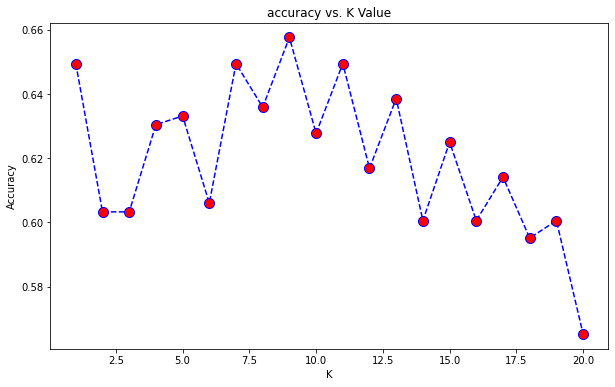

In [15]:
#plot accuracy v k values
plt.figure(figsize=(10,6))
plt.plot(range(1,21),acc,color = 'blue',linestyle='dashed', 
         marker='o',markerfacecolor='red', markersize=10)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('Accuracy')
print("Maximum accuracy:",max(acc),"at K =",(acc.index(max(acc))+1))

In [14]:
#Test output final k value
num_N = 9
from sktime.classification.distance_based import KNeighborsTimeSeriesClassifier
knn = KNeighborsTimeSeriesClassifier(n_neighbors=num_N, metric="dtw")

#Time to run the algorithm
from time import time
start = time()
knn.fit(X_ts_train, y_train)
end = time() - start
print('Total Time : '+str(round(end,2))+' seconds\n\n')



Total Time : 0.04 seconds




In [17]:
#Accuracy Score
print("accuracy score:")
knn.score(X_ts_test, y_test)


accuracy score:


0.6315217391304347